In [13]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)


import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt 
matplotlib.rcdefaults()

from pathlib import Path
matplotlib_rc = { 
    # 'text': {'usetex': True}, 
    'font': {'family': 'serif'} } # Apply changes for k, v in matplotlib_rc.items(): rc(k, **v)
for k, v in matplotlib_rc.items():
          rc(k, **v)

from matplotlib import rcParams

FIGSIZE = (3, 3)
rcParams["figure.figsize"] = FIGSIZE

## Step 1: Initialize data

In [14]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type', 'DonorNumber'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'cell_type', 
                    'size_factor_covariate': 'DonorNumber',
                    'guidance_weights': {'cell_type': 1, 'DonorNumber': 1}
                 }

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Step 2: Initialize encoder

In [15]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_train_autoencoder_neurips_whole_genome/eabc6534-947b-4486-8012-c9e351b297ca/checkpoints/epoch_59.ckpt"

In [16]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [17]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [18]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/GUIDED_MULTILAB_NEURIPS/04ddda45-0e7f-4d9c-84fa-00386d0e9668/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [19]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-0.0612,  1.5668, -1.3121,  ..., -0.7325,  0.6893,  1.8416],
        [ 0.4109,  2.6033, -0.3698,  ...,  0.9182, -0.2323,  1.5193],
        [-0.9319, -0.0695, -0.7243,  ...,  0.2298,  1.2798,  1.0088],
        ...,
        [ 0.5542,  0.1984,  2.4724,  ..., -0.1529,  0.4955, -0.1487],
        [-1.0265, -0.0152,  0.3432,  ..., -0.9004, -0.3074,  1.1375],
        [ 0.5308, -0.5272, -2.2899,  ..., -0.5379,  0.7789,  1.2259]],
       device='cuda:0', requires_grad=True)


Initializations

In [20]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'cell_type': 1, 'DonorNumber': 1},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=14087, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
         

In [21]:
generative_model.denoising_model.guided_conditioning = True

**Check the data**

In [22]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
adata_original.X = adata_original.layers["X_counts"].A.copy()
X = torch.tensor(adata_original.layers["X_counts"].todense())

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Train oracles

In [23]:
from oracle_training import train_mlp_classifier
oracle_cell_type,le_cell_type = train_mlp_classifier(adata_original,
                     "cell_type", 
                     hidden_layer_sizes=(64, 32),
                     epochs=300,
                     batch_size=32,
                     lr=0.001, 
                     device='cuda')

Epoch 10/300, Loss: 0.0735
Test Accuracy: 0.8438
Epoch 20/300, Loss: 0.0003
Test Accuracy: 0.8610
Epoch 30/300, Loss: 0.0120
Test Accuracy: 0.8480
Epoch 40/300, Loss: 0.0237
Test Accuracy: 0.8554
Epoch 50/300, Loss: 0.0003
Test Accuracy: 0.8541
Epoch 60/300, Loss: 0.0000
Test Accuracy: 0.8538
Epoch 70/300, Loss: 0.3382
Test Accuracy: 0.8482
Epoch 80/300, Loss: 0.0008
Test Accuracy: 0.8505
Epoch 90/300, Loss: 0.0002
Test Accuracy: 0.8438
Epoch 100/300, Loss: 0.0000
Test Accuracy: 0.8463
Epoch 110/300, Loss: 0.0000
Test Accuracy: 0.8505
Epoch 120/300, Loss: 0.0016
Test Accuracy: 0.8546
Epoch 130/300, Loss: 0.0000
Test Accuracy: 0.8394
Epoch 140/300, Loss: 0.0001
Test Accuracy: 0.8560
Epoch 150/300, Loss: 0.2184
Test Accuracy: 0.8568
Epoch 160/300, Loss: 0.0000
Test Accuracy: 0.8427
Epoch 170/300, Loss: 0.0000
Test Accuracy: 0.8585
Epoch 180/300, Loss: 0.0000
Test Accuracy: 0.8488
Epoch 190/300, Loss: 0.0000
Test Accuracy: 0.8610
Epoch 200/300, Loss: 0.0000
Test Accuracy: 0.8574
Epoch 210

In [25]:
oracle_donor,le_donor = train_mlp_classifier(adata_original,
                     "DonorNumber", 
                     hidden_layer_sizes=(64, 32),
                     epochs=300,
                     batch_size=32,
                     lr=0.001, 
                     device='cuda')

Epoch 10/300, Loss: 0.0034
Test Accuracy: 0.9565
Epoch 20/300, Loss: 0.0002
Test Accuracy: 0.9560
Epoch 30/300, Loss: 0.0008
Test Accuracy: 0.9615
Epoch 40/300, Loss: 0.0000
Test Accuracy: 0.9601
Epoch 50/300, Loss: 0.0034
Test Accuracy: 0.9762
Epoch 60/300, Loss: 0.0000
Test Accuracy: 0.9790
Epoch 70/300, Loss: 0.0000
Test Accuracy: 0.9767
Epoch 80/300, Loss: 0.0000
Test Accuracy: 0.9798
Epoch 90/300, Loss: 0.0000
Test Accuracy: 0.9787
Epoch 100/300, Loss: 0.0000
Test Accuracy: 0.9698
Epoch 110/300, Loss: 0.0000
Test Accuracy: 0.9723
Epoch 120/300, Loss: 0.0226
Test Accuracy: 0.9657
Epoch 130/300, Loss: 0.0000
Test Accuracy: 0.9601
Epoch 140/300, Loss: 0.0000
Test Accuracy: 0.9759
Epoch 150/300, Loss: 0.0000
Test Accuracy: 0.9729
Epoch 160/300, Loss: 0.0000
Test Accuracy: 0.9770
Epoch 170/300, Loss: 0.0000
Test Accuracy: 0.9778
Epoch 180/300, Loss: 0.0000
Test Accuracy: 0.9784
Epoch 190/300, Loss: 0.0000
Test Accuracy: 0.9751
Epoch 200/300, Loss: 0.0000
Test Accuracy: 0.9751
Epoch 210

## Generate intersection

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


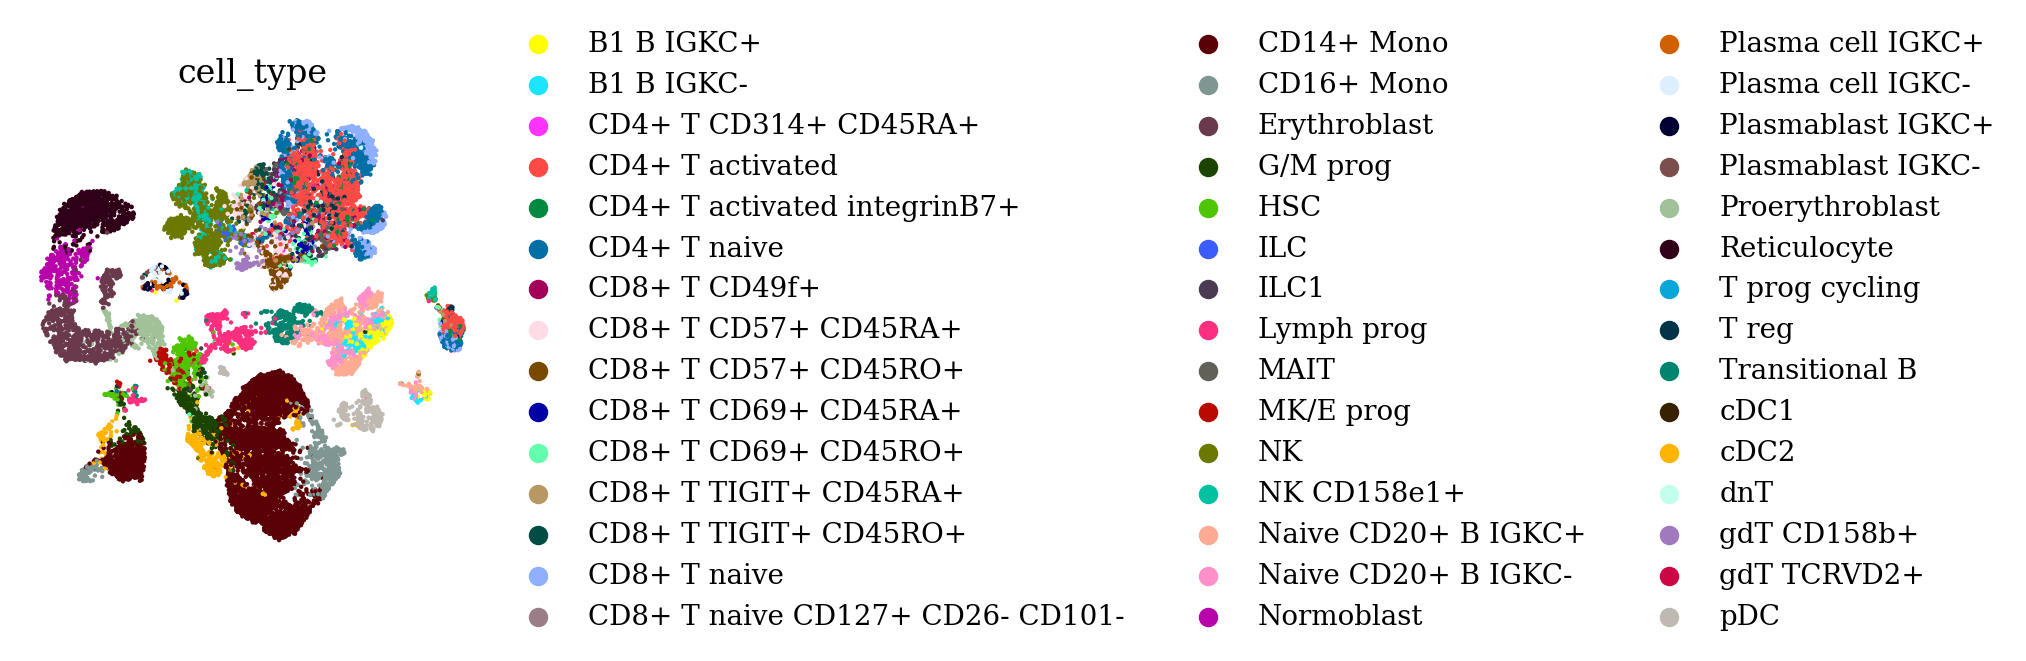

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


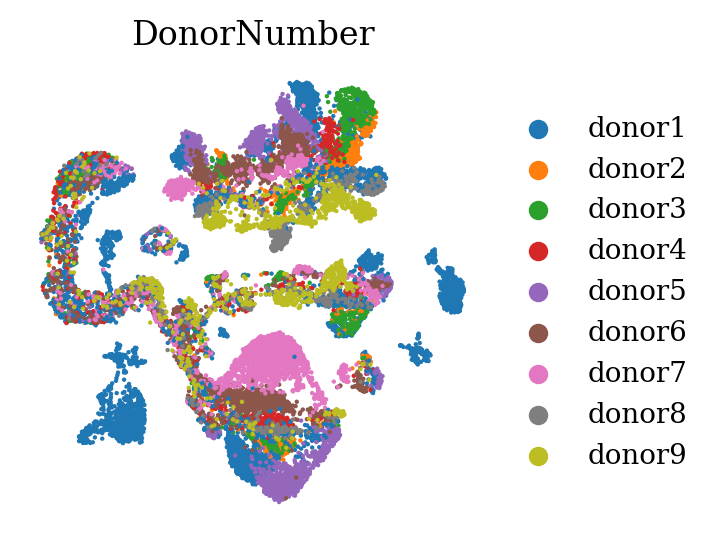

In [26]:
sc.pl.umap(adata_original, color=["cell_type"], s=10)
sc.pl.umap(adata_original, color=["DonorNumber"], s=10)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


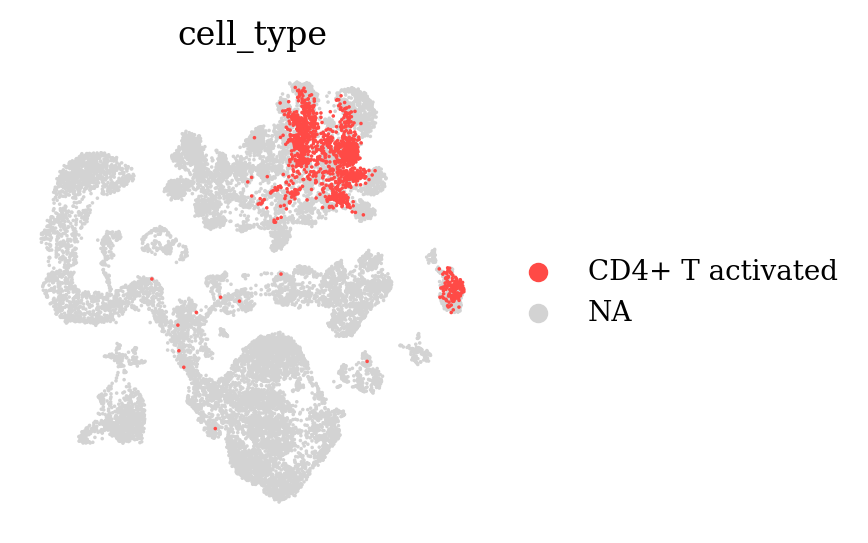

In [27]:
sc.pl.umap(adata_original, color="cell_type", groups="CD4+ T activated")

# COMBINATION OF CONDITIONS 

In [ ]:
generative_model.guidance_weights

In [ ]:
dataset.id2cov["cell_type"]

In [ ]:
dataset.id2cov["DonorNumber"]

In [ ]:
# Pick condition 
covariates_cell_types = 'CD14+ Mono'
covariates_donor = 'donor1'

# Get the labels
condition_id_ct = dataset.id2cov["cell_type"][covariates_cell_types]
condition_id_donor = dataset.id2cov["DonorNumber"][covariates_donor]

# Get the labels
adata_cond = adata_original[np.logical_and(adata_original.obs.cell_type==covariates_cell_types, 
                                           adata_original.obs.DonorNumber==covariates_donor)]
n_to_generate = adata_cond.shape[0]

classes = {"cell_type": condition_id_ct*torch.ones(n_to_generate).long(), 
           "DonorNumber": condition_id_donor*torch.ones(n_to_generate).long()}

classes_str = {"cell_type": [covariates_cell_types for n in range(n_to_generate)], 
           "DonorNumber": [covariates_donor for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [ ]:
X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="cell_type", 
                                        size_factor_covariate="cell_type",
                                        conditioning_covariates=["cell_type", "DonorNumber"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

X_generated = X_generated.to("cpu")

adata_generated = sc.AnnData(X=X_generated.numpy())

In [ ]:
adata_merged = join_real_generated(adata_original, adata_generated, True, classes_str, ["cell_type", "DonorNumber"])

In [ ]:
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

In [ ]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="cell_type")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="DonorNumber")
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated", s=10)

In [ ]:
# sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated",s=10)
sc.pl.umap(adata_merged, color="cell_type", groups="CD14+ Mono",s=10)
sc.pl.umap(adata_merged, color="DonorNumber", groups="donor1",s=10, palette="jet", add_outline=True)

## Experiment guidance weights

In [28]:
results_oracle = {"weight_step": [],
                    "cell_type_pred": [],
                    "donor_pred": []
                  }

In [29]:
covariates_cell_types = 'CD14+ Mono'
covariates_donor = 'donor1'

donor_weight_data = {}

# Get the labels
condition_id_ct = dataset.id2cov["cell_type"][covariates_cell_types]
condition_id_donor = dataset.id2cov["DonorNumber"][covariates_donor]

adata_cond = adata_original[np.logical_and(adata_original.obs.cell_type==covariates_cell_types, 
                                           adata_original.obs.DonorNumber==covariates_donor)]
n_to_generate = adata_cond.shape[0]

classes = {"cell_type": condition_id_ct*torch.ones(n_to_generate).long(), 
           "DonorNumber": condition_id_donor*torch.ones(n_to_generate).long()}

classes_str = {"cell_type": [covariates_cell_types for n in range(n_to_generate)], 
           "DonorNumber": [covariates_donor for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

for donor_weight in [0, 1, 2, 5]:
    X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=2, 
                                        theta_covariate="cell_type", 
                                        size_factor_covariate="cell_type",
                                        conditioning_covariates=["cell_type", "DonorNumber"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors, 
                                        guidance_weights={'cell_type': 1, 'DonorNumber': donor_weight})

    with torch.no_grad():
        results_oracle["weight_step"] += [donor_weight] * X_generated.shape[0]
        results_oracle["cell_type_pred"].append(torch.softmax(oracle_cell_type(X_generated), dim=1)[:, condition_id_ct].cpu().numpy())
        results_oracle["donor_pred"].append(torch.softmax(oracle_donor(X_generated), dim=1)[:, condition_id_donor].cpu().numpy())
            
    X_generated = X_generated.to("cpu")
        
    donor_weight_data[donor_weight] = X_generated

In [30]:
results_oracle["cell_type_pred"] = np.concatenate(results_oracle["cell_type_pred"])
results_oracle["donor_pred"] = np.concatenate(results_oracle["donor_pred"])
results_oracle = pd.DataFrame(results_oracle)
results_oracle.groupby("weight_step").mean()

,cell_type_pred,donor_pred
weight_step,,
0,0.970882,0.401368
1,0.962390,0.874976
2,0.965212,0.990959
5,0.914927,0.998632


In [31]:
adata_joint_mat = [adata_original.layers["X_counts"].A.copy()]
weights = ["Real data" for _ in range(len(adata_joint_mat[0]))]
donor = list(adata_original.obs["DonorNumber"])
cell_type = list(adata_original.obs["cell_type"])


for w in donor_weight_data:
    adata_joint_mat.append(donor_weight_data[w])
    weights += [str(w) for _ in range(len(donor_weight_data[w]))]
    donor += ["g_donor1" for _ in range(len(donor_weight_data[w]))]
    cell_type += ["g_CD14+ Mono" for _ in range(len(donor_weight_data[w]))]

# adata_joint_mat.append(X_generated_uncond)
# weights += ["0_0" for _ in range(len(X_generated_uncond))]
# donor += ["g_donor1 0_0" for _ in range(len(X_generated_uncond))]
# cell_type += ["g_CD14+ 0_0" for _ in range(len(X_generated_uncond))]

In [32]:
obs = pd.DataFrame(weights)
obs.columns = ["guidance weight"]
obs["donor"] = donor
obs["cell_type"] = cell_type

In [33]:
adata_joint = sc.AnnData(X=np.concatenate(adata_joint_mat,axis=0),
                        obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [34]:
sc.pp.normalize_total(adata_joint, target_sum=1e4)
sc.pp.log1p(adata_joint)
sc.tl.pca(adata_joint)
sc.pp.neighbors(adata_joint)
sc.tl.umap(adata_joint)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


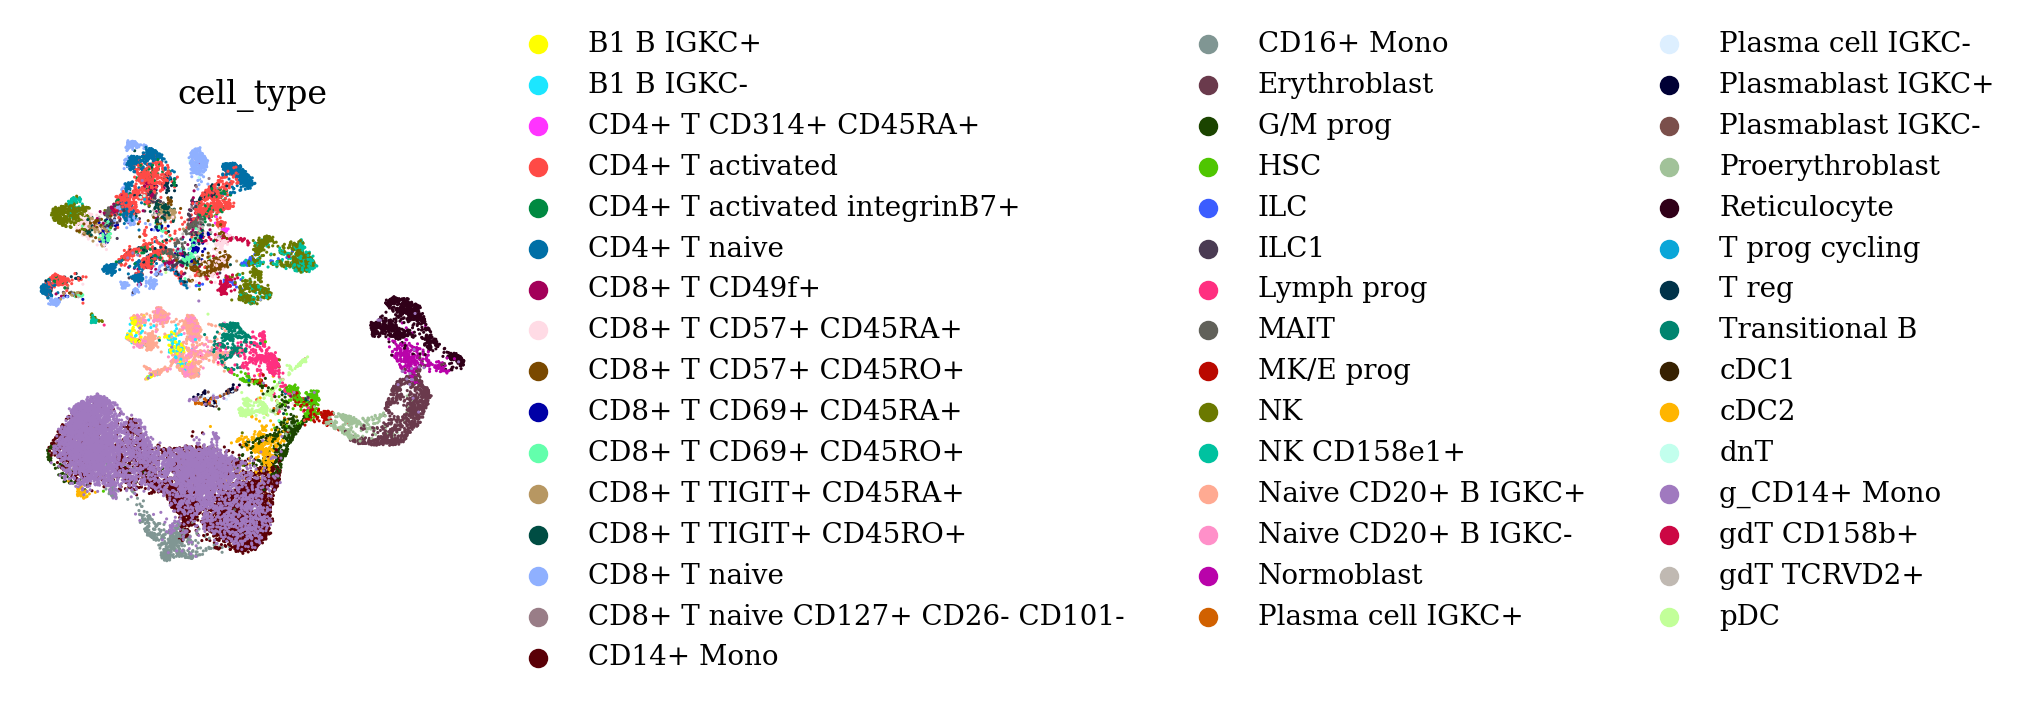

In [35]:
sc.pl.umap(adata_joint, color="cell_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


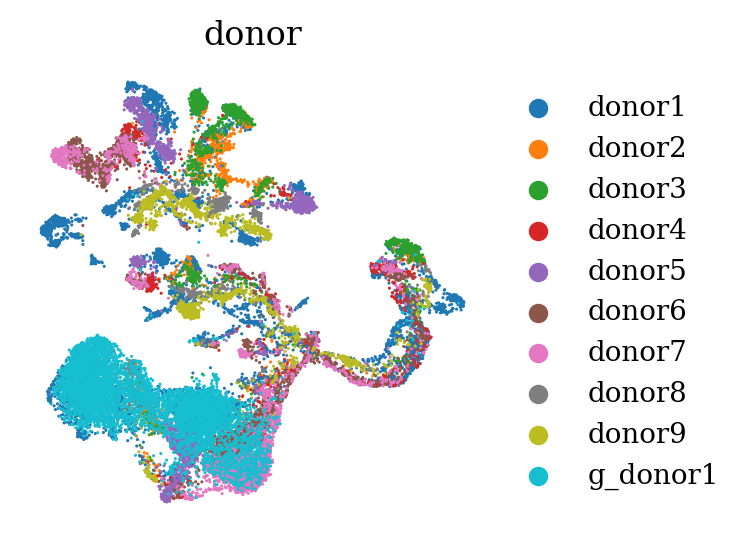

In [36]:
sc.pl.umap(adata_joint, color="donor")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


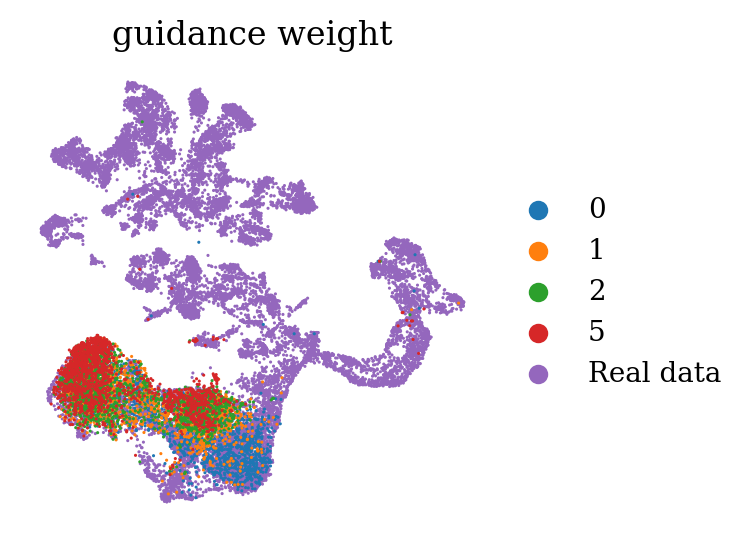

In [37]:
sc.pl.umap(adata_joint, color="guidance weight")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


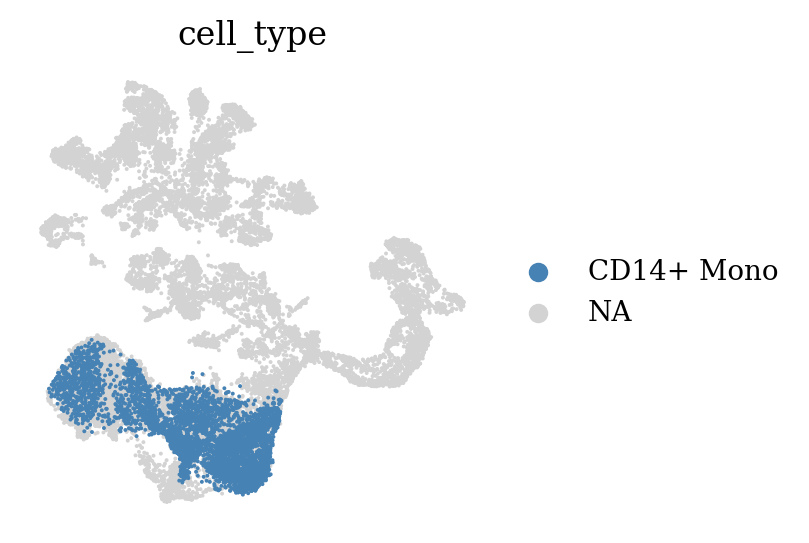

In [38]:
adata_joint.uns["cell_type_colors"][15]="steelblue"
sc.pl.umap(adata_joint, color='cell_type', groups="CD14+ Mono",s=8,save="real_neurips_cd14.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


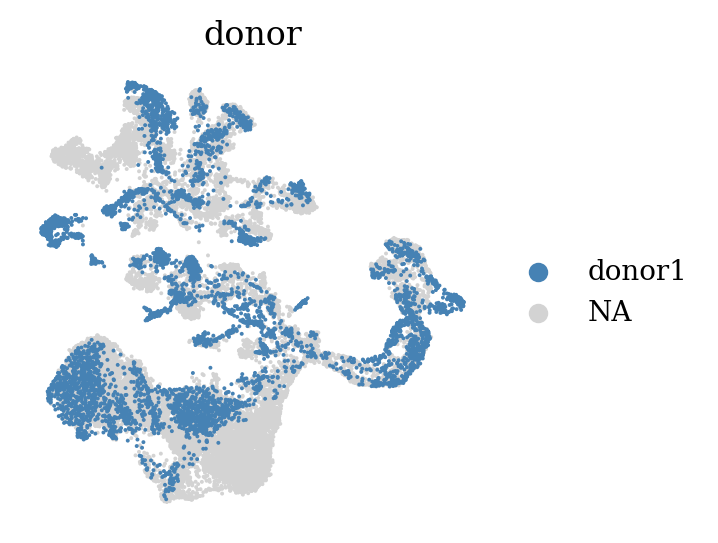

In [39]:
adata_joint.uns["donor_colors"][0]="steelblue"
sc.pl.umap(adata_joint, color='donor', groups="donor1",s=8,save="real_neurips_d1.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


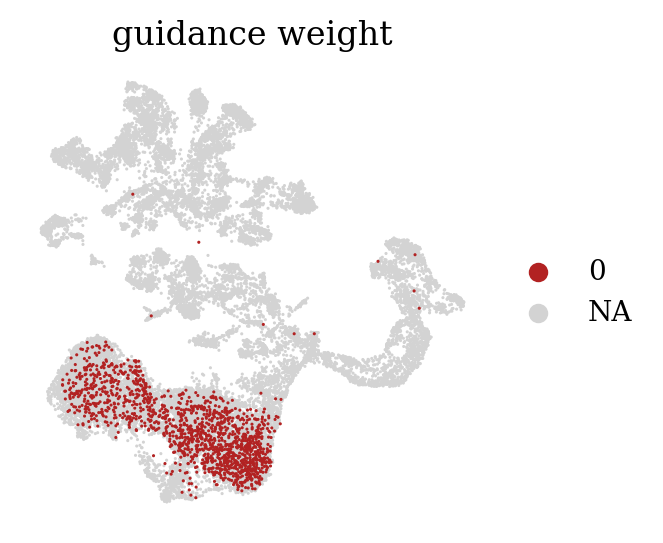

In [40]:
adata_joint.uns["guidance weight_colors"][0] = "firebrick"
sc.pl.umap(adata_joint, color='guidance weight', groups="0", save="neurips_cd14_d1_0.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


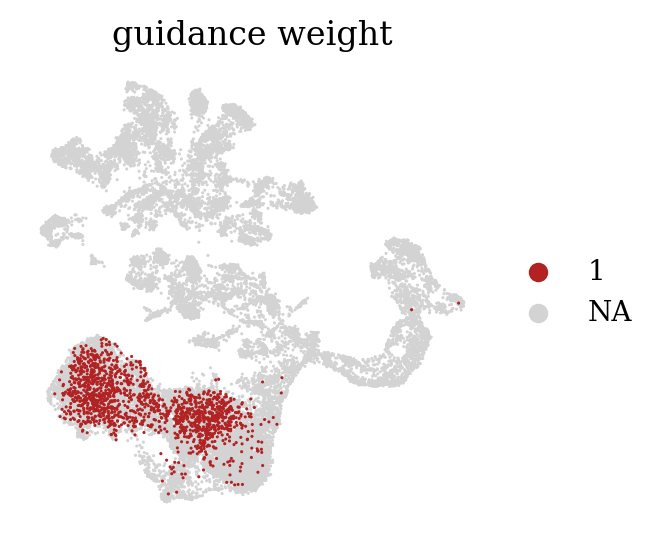

In [41]:
adata_joint.uns["guidance weight_colors"][1] = "firebrick"
sc.pl.umap(adata_joint, color='guidance weight', groups="1", save="neurips_cd14_d1_1.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


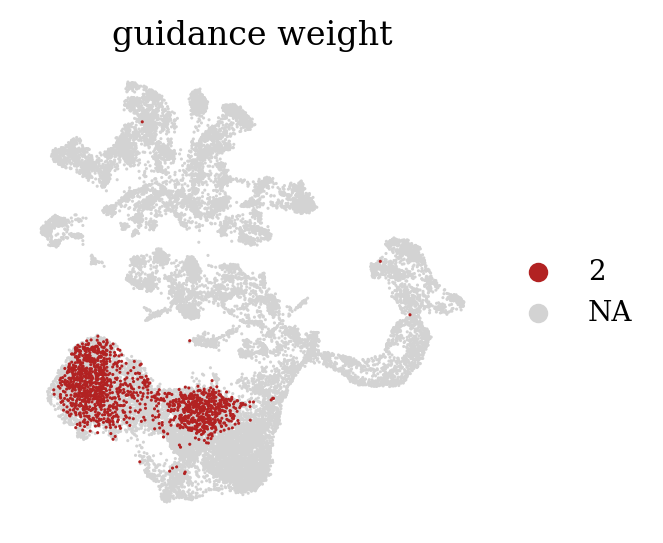

In [42]:
adata_joint.uns["guidance weight_colors"][2] = "firebrick"
sc.pl.umap(adata_joint, color='guidance weight', groups="2", save="neurips_cd14_d1_2.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


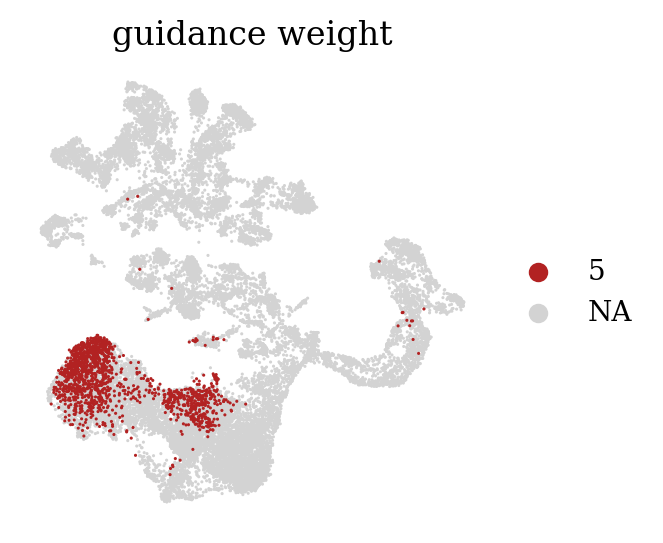

In [43]:
adata_joint.uns["guidance weight_colors"][3] = "firebrick"
sc.pl.umap(adata_joint, color='guidance weight', groups="5", save="neurips_cd14_d1_5.png")

Add uncond generation

In [ ]:
classes = {"cell_type": condition_id_ct*torch.ones(12000).long(), 
           "DonorNumber": condition_id_donor*torch.ones(12000).long()}
X_generated_uncond = generative_model.sample(batch_size=12000,
                                    n_sample_steps=2, 
                                    theta_covariate="cell_type", 
                                    size_factor_covariate="cell_type",
                                    conditioning_covariates=["cell_type", "DonorNumber"],
                                    covariate_indices=classes, 
                                    log_size_factor=None, 
                                    guidance_weights={'cell_type': 0, 'DonorNumber': 0})

X_generated_uncond = X_generated_uncond.to("cpu")

In [ ]:
# adata_joint_uncond.obs["dataset_type"] = np.where(adata_joint_uncond.obs["dataset_type"]=="gen", "Generated", "Real")

In [ ]:
gener_uncond = sc.AnnData(X = X_generated_uncond.numpy())

In [ ]:
adata_joint_uncond = sc.AnnData(X=np.concatenate([adata_original.layers["X_counts"].A, gener_uncond.X], axis=0), 
                               obs={"dataset_type":["real" for _ in range(len(adata_original))]+["gen" for _ in range(len(gener_uncond))]})

In [ ]:
sc.pp.normalize_total(adata_joint_uncond, target_sum=1e4)
sc.pp.log1p(adata_joint_uncond)

In [ ]:
sc.tl.pca(adata_joint_uncond)
sc.pp.neighbors(adata_joint_uncond)
sc.tl.umap(adata_joint_uncond)

In [ ]:
# Load the Set1 color palette from matplotlib
set1_palette = plt.get_cmap('Set1').colors

In [ ]:
sc.pl.umap(adata_joint_uncond, color="dataset_type", palette=set1_palette, save="neurips_0_0.png")